In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace

In [3]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
# Enable cuDNN autotuner. This runs a short benchmark and selects the convolution algorithm with the best performance.
torch.backends.cudnn.benchmark = True  

In [7]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')

path.mkdir(exist_ok=True)

In [8]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [9]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [10]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [11]:
list(path.glob('*')) # list all files

[PosixPath('/data/s4314719/image-captioning/__MACOSX'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.trainImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_Dataset.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.lemma.token.txt'),
 PosixPath('/data/s4314719/image-captioning/ExpertAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/readme.txt'),
 PosixPath('/data/s4314719/image-captioning/Flicker8k_Dataset'),
 PosixPath('/data/s4314719/image-captioning/CrowdFlowerAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.testImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.token.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_text.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.devImages.txt')]

In [12]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


In [13]:
from torch.utils.data import Dataset, DataLoader
from src.caption_utils import preprocess_tokens
from PIL import Image

class FlickrDataset(Dataset):
    unk_token = '<UNKNOWN>'
    ns_token = '<NOTSET>'
    start_token = '<START>'
    end_token = '<END>'
        
    def __init__(self, img_dir, img_captions_enc, known_words, ann_file, img_ids, split, trnsf=None):
        self.img_dir = Path(img_dir)
        self.known_words = known_words
        self.ann_file = Path(ann_file)
        self.trnsf = trnsf
        self.split = split
        self.annotations = {}
        self.targets = {}
        
        assert self.split in ['train', 'eval', 'test']
        
        #img_captions_enc, self.known_words, _ = preprocess_tokens(ann_file)
        
        end_idx = list(self.known_words.keys()).index(self.end_token)
        # the targets are the captions shifted one place to the right.
        target_lst = [[c[i] for i in range(1, len(c)) if c[i-1] != self.ns_token] 
                      for c in list(zip(*img_captions_enc))[1]]
        
        # iterate through the annotation file and create (image, caption) pairs
        img_ids = Path(img_ids).read_text().split('\n')
        for i, (img_id, annotation) in enumerate(img_captions_enc):
            # TODO: we only consider the first of 5 annotations for each image. Do something with the other four.
            if img_id in self.annotations or not (img_dir/img_id).exists() or not img_id in img_ids:
                continue
            self.annotations.update({img_id: annotation})
            self.targets.update({img_id: target_lst[i]})
        self.img_ids = list(self.annotations.keys())
        
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        annotation = self.annotations[img_id]
        im = Image.open(self.img_dir/img_id)
        if self.trnsf is not None:
            im = self.trnsf(im)
        target = self.targets[img_id]
        return im, annotation, target, self.split
    
    def decode_caption(self, caption):
        res = ''
        for i, word_idx in enumerate(caption):
            word = list(self.known_words.keys())[word_idx]
            res += word
            if word == self.end_token:
                break
            res += ' '
        return res
    
    def encode_caption(self, caption):
        res = []
        for i, word in enumerate(caption):
            if word in known_words:
                # this is not very efficient; can be improved by creating a dictionary of (word, encoding) pairs
                res.append(list(self.known_words.keys()).index(word))
            else:
                res.append(list(self.known_words.keys()).index(self.unk_token))
        return res

### Preprocessing the images

In [14]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
# mean = np.array([0.4629, 0.4468, 0.4050])
# std = np.array([0.2661, 0.2587, 0.2727])

# normalization data for pretrained PyTorch model
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [15]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

### Preprocessing the captions

In [16]:
# Calls the preprocessing of the captions which may take a while (progress is printed)
img_captions_enc, known_words, _ = preprocess_tokens(ann_file)
vocab_size = len(known_words)
vocab_size

30/03/2021 21:04:06 - src.caption_utils - INFO - Creating word dictionary: 0/40461
30/03/2021 21:04:07 - src.caption_utils - INFO - Creating word dictionary: 10000/40461
30/03/2021 21:04:09 - src.caption_utils - INFO - Creating word dictionary: 20000/40461
30/03/2021 21:04:10 - src.caption_utils - INFO - Creating word dictionary: 30000/40461
30/03/2021 21:04:11 - src.caption_utils - INFO - Creating word dictionary: 40000/40461
30/03/2021 21:04:12 - src.caption_utils - INFO - Replacing tokens with numerical values: 0/40461
30/03/2021 21:04:23 - src.caption_utils - INFO - Replacing tokens with numerical values: 10000/40461
30/03/2021 21:04:34 - src.caption_utils - INFO - Replacing tokens with numerical values: 20000/40461
30/03/2021 21:04:44 - src.caption_utils - INFO - Replacing tokens with numerical values: 30000/40461
30/03/2021 21:04:54 - src.caption_utils - INFO - Replacing tokens with numerical values: 40000/40461


5223

### Split data up into train and evaluation set

In [17]:
# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, img_captions_enc, known_words, ann_file,
                         path/'Flickr_8k.trainImages.txt', 'train', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, img_captions_enc, known_words, ann_file,
                        path/'Flickr_8k.devImages.txt', 'eval', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

(6000, 1000)

In [18]:
ds_train[0][1], ds_train[0][2]

([2, 4, 43, 5, 4, 91, 171, 8, 120, 54, 4, 397, 13, 394, 5, 29, 1, 694, 3],
 [4, 43, 5, 4, 91, 171, 8, 120, 54, 4, 397, 13, 394, 5, 29, 1, 694, 3])

In [19]:
# show an example from the dataset
img = '1000268201_693b08cb0e.jpg'
caption = ds_train.annotations[img]
print(img)
print(caption)
print(ds_train.decode_caption(caption))

1000268201_693b08cb0e.jpg
[2, 4, 43, 5, 4, 91, 171, 8, 120, 54, 4, 397, 13, 394, 5, 29, 1, 694, 3]
<START> a child in a pink dress is climbing up a set of stairs in an <UNKNOWN> way <END>


### Visualizing the dataset

In [20]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)

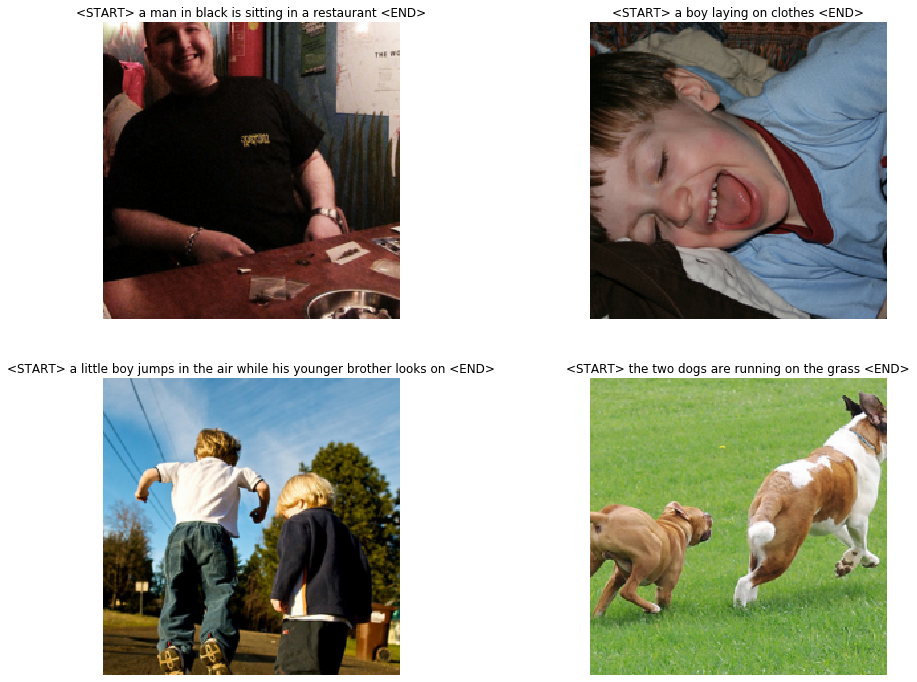

In [21]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption, *_ = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(ds_train.decode_caption(caption))
    imshow(im)
    plt.axis('off')

In [22]:
# plot the distribution of captions lengths
#caption_lengths = [smpl[2] for smpl in ds_train]  # this takes a while
# plt.hist(caption_lengths)
# plt.title(f'caption lengths, mean = {np.mean(caption_lengths):.1f}')
# plt.xlabel('caption length')
# plt.ylabel('frequency')
# plt.show()

### Model initialization and training

In [146]:
# hyperparameters
num_hidden = 512
embedding_dim = 512
batch_size = 64
epochs = 400
num_workers = 0
num_layers = 1

In [147]:
from src.models import EncoderDecoder, LSTMDecoder, get_encoder, ResNetEncoder

# TODO: this should not be here...
pad_token_idx = list(ds_train.known_words.keys()).index(FlickrDataset.ns_token)
start_token_idx = list(ds_train.known_words.keys()).index(FlickrDataset.start_token)

# encoder = get_encoder(num_hidden)
encoder = ResNetEncoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, vocab_size, pad_token_idx, start_token_idx, num_layers=num_layers)
encoder, decoder = encoder.to(device), decoder.to(device)

# encoder.fc.register_full_backward_hook(lambda m, i, o: print(i.data.norm().item(), o.data.norm().item()))
model = EncoderDecoder(encoder, decoder, device)
model = model.to(device);

30/03/2021 23:26:12 - src.models - INFO - Number of trainable parameters: 29002663


In [273]:
# model

In [148]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters(), 0.01)
# optimizer = optim.SGD(model.parameters(), 0.001, momentum=0.9)

In [149]:
# overfit on a mini dataset
ds_train_mini = torch.utils.data.Subset(ds_train, [random.randint(0, len(ds_train)-1) for _ in range(3)])
ds_eval_mini = torch.utils.data.Subset(ds_eval, [0, 1])

In [150]:
from src.trainer import Trainer, TrainerConfig
from src.utils import collate_fn

config = TrainerConfig(batch_size=batch_size, epochs=epochs, 
                       num_workers=num_workers, track_grad_norm=False,
                       track_loss=False, track_accuracy=False)
# trainer = Trainer(config, model, optimizer, ds_train_mini, collate_fn=collate_fn)
trainer = Trainer(config, model, optimizer, ds_train, ds_eval, collate_fn)

In [151]:
trainer.train()

30/03/2021 23:30:08 - src.trainer - INFO - Epoch 0 - train_loss: 4.5557


ValueError: Expected target size (128, 30), got torch.Size([128, 27])

### Sample some predictions

In [142]:
def predict_img(idx):
    img, caption, *_ = ds_train_mini[idx]
    imshow(img)
    img = img.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        all_logits, _, _, _, sampled_ids = model(img, 'test')
    return sampled_ids.squeeze().cpu().numpy(), caption

<START> a race car coming around a curve on a gravel course creating lots of dust <END>
<START> a race car coming around a curve on a gravel course creating lots of dust <END>


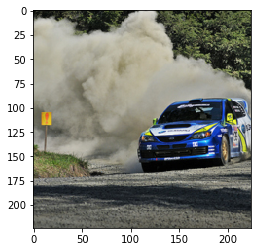

In [143]:
sampled_ids, caption = predict_img(0)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

<START> a woman wearing black a woman wearing white and a man wearing a grey suit sit on a green bench in front of <UNKNOWN> s restaurant <END>
<START> a woman wearing black a woman wearing white and a man wearing a grey suit sit on a green bench in front of <UNKNOWN> s restaurant <END>


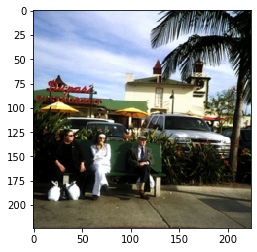

In [144]:
sampled_ids, caption = predict_img(1)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

<START> a big brown dog plays with a small white dog near a ball <END>
<START> a big brown dog plays with a small white dog near a ball <END>


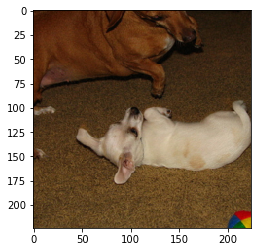

In [145]:
sampled_ids, caption = predict_img(2)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

In [1]:
trainer.losses['eval']

NameError: name 'trainer' is not defined

In [73]:
# Plot the gradients over time
# plt.plot(trainer.grad_norms)
# plt.show()